# Figure 1
This figure shows how the proposed emergent relationships fare in CMIP5 and CMIP6 ensembles.

In [1]:
# import the necessary libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import signal
from scipy import stats
from scipy.stats import linregress
from scipy.signal import detrend
import scipy.signal as signal
from statsmodels.api import tsa
import xarray as xr
import warnings
import zarr

# style guide for plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

def compute_cox(x):
    x = x[~np.isnan(x)]
    psi_vals=[]
    for i in np.arange(0, len(x)-55):
        y = signal.detrend(x[i:i+55])
        auto_m1 = tsa.acf(y,nlags=1) # autocorrelation function from statsmodels
        auto_m1b = auto_m1[1]    # select 1 lag autocorrelation value
        sigma_m1= np.std(y)
        log_m1= np.log(auto_m1b)
        log_m1b = np.abs(log_m1)   # take absolute value
        sqrt_m1 = np.sqrt(log_m1b)
        psi = sigma_m1/sqrt_m1
        psi_vals.append(psi)
    return np.nanmean(psi_vals)

def compute_nijsse(x, length=10):
    # remove NaNs from the timeseries
    x = np.array(x)
    mask = ~np.isnan(x)
    x = x[mask]
    # fill it with slopes
    slopes = []
    i = 0
    while i < len(x)-length:
        slope, intercept, r, p, se = linregress(np.arange(0,length), x[i:i+length])
        slopes.append(length*slope)
        i+=length
    return np.nanstd(slopes)

In [2]:
from pathlib import Path
import os
notebooks_dir = Path(os.path.abspath('__file__')).parent.parent
data_dir = notebooks_dir.parent / 'data'

In [6]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

In [3]:
cmip5_psi = pd.read_csv(data_dir/'data_fig1a_cmip5.csv')
cmip6_psi = pd.read_csv(data_dir/'data_fig1a_cmip6.csv')

# Load Sigma and ECS values for CMIP5 and CMIP6 directly from CSV files
cmip5_data = pd.read_csv(data_dir/'data_fig1b_cmip5.csv')
cmip6_data = pd.read_csv(data_dir/'data_fig1b_cmip6.csv')

In [4]:

cmip5_sigma = cmip5_data['Sigma'].tolist()
cmip5_sigma_ecs = cmip5_data['ECS'].tolist()

cmip6_sigma = cmip6_data['Sigma'].tolist()
cmip6_sigma_ecs = cmip6_data['ECS'].tolist()

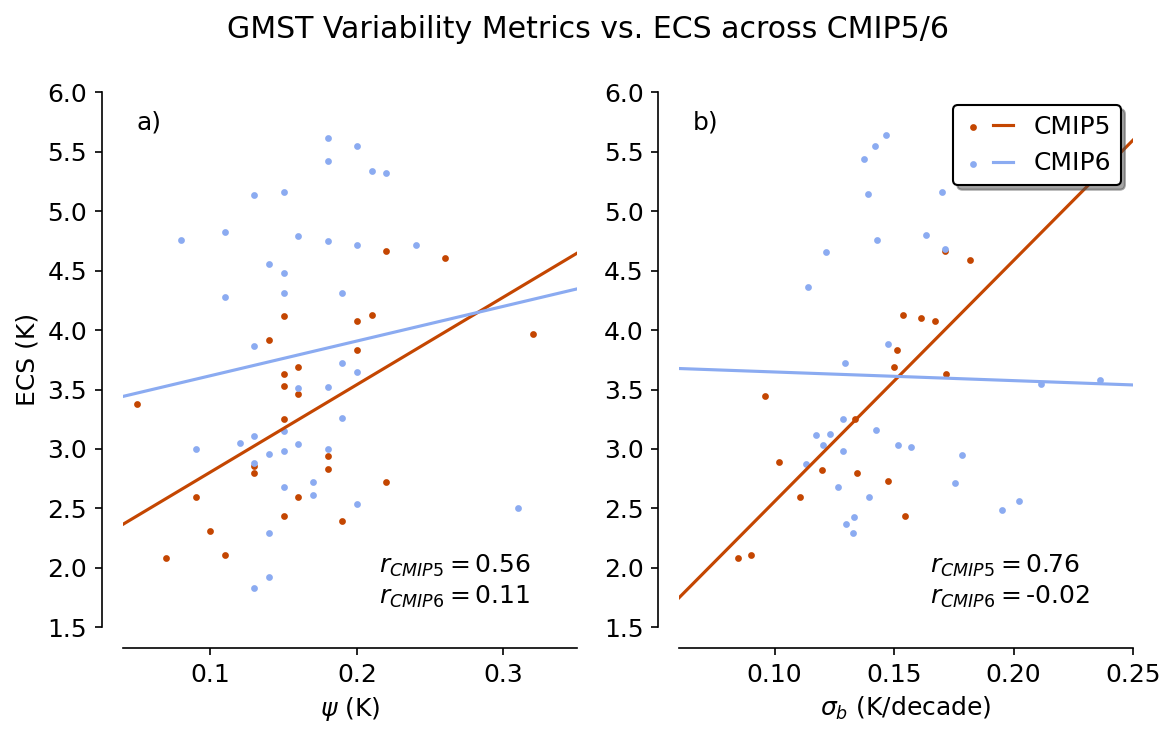

In [7]:
cmip5_color = '#C44601'
cmip6_color = '#8BABF1'
marker_size = 5

fig, axs = plt.subplots(1, 2, figsize = (8, 5), sharey=True)

# plot the actual data
plot_1 = axs[0].scatter(cmip5_psi['Psi'], cmip5_psi['ECS'], color = cmip5_color, s = marker_size)
plot_2 = axs[0].scatter(cmip6_psi['Psi'], cmip6_psi['ECS'], color = cmip6_color, s = marker_size)
plot_3 = axs[1].scatter(cmip5_sigma, cmip5_sigma_ecs, color = cmip5_color, s = marker_size)
plot_4 = axs[1].scatter(cmip6_sigma, cmip6_sigma_ecs, color = cmip6_color, s = marker_size)

# linear regression
slope, intercept, r, p, se = linregress(cmip5_psi['Psi'], cmip5_psi['ECS'])
x = np.linspace(0, 1, 100)
trend_1, = axs[0].plot(x, slope*x+intercept, color = cmip5_color)
r_cmip5_psi = r

slope, intercept, r, p, se = linregress(cmip6_psi['Psi'], cmip6_psi['ECS'])
x = np.linspace(0, 1, 100)
trend_2, = axs[0].plot(x, slope*x+intercept, color = cmip6_color)
r_cmip6_psi = r

slope, intercept, r, p, se = linregress(cmip5_sigma, cmip5_sigma_ecs)
x = np.linspace(0, 1, 100)
trend_3, = axs[1].plot(x, slope*x+intercept, color = cmip5_color)
r_cmip5_sigma = r

slope, intercept, r, p, se = linregress(cmip6_sigma, cmip6_sigma_ecs)
x = np.linspace(0, 1, 100)
trend_4, = axs[1].plot(x, slope*x+intercept, color = cmip6_color)
r_cmip6_sigma = r

fig.suptitle('GMST Variability Metrics vs. ECS across CMIP5/6')
axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel(r'$\psi$ (K)')
axs[1].set_xlabel(r'$\sigma_{b}$ (K/decade)')
axs[0].set_xlim((0.04,0.35))
axs[0].set_ylim((1.5,6))
axs[1].set_ylim((1.5,6))
axs[1].set_xlim((0.06,0.25))
axs[1].legend([(plot_1, trend_1), (plot_2, trend_2)], ['CMIP5', 'CMIP6'], handler_map = {tuple : HandlerTuple(None)}, framealpha=1, edgecolor='black', loc = 'upper right', shadow=True)

axs[0].text(0.215, 1.7, r'$r_{CMIP5}=$'+str(np.round(r_cmip5_psi,2))+'\n'+r'$r_{CMIP6}=$'+str(np.round(r_cmip6_psi,2)))
axs[1].text(0.165, 1.7, r'$r_{CMIP5}=$'+str(np.round(r_cmip5_sigma,2))+'\n'+r'$r_{CMIP6}=$'+str(np.round(r_cmip6_sigma,2)))

axs[0].annotate(xy=(0.03,0.93), text='a)', xycoords='axes fraction')
axs[1].annotate(xy=(0.03,0.93), text='b)', xycoords='axes fraction')


# Move left and bottom spines outward by 10 points
axs[0].spines.left.set_position(('outward', 10))
axs[0].spines.bottom.set_position(('outward', 10))
# Hide the right and top spines
axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
axs[0].yaxis.set_ticks_position('left')
axs[0].xaxis.set_ticks_position('bottom')

# Move left and bottom spines outward by 10 points
axs[1].spines.left.set_position(('outward', 10))
axs[1].spines.bottom.set_position(('outward', 10))
# Hide the right and top spines
axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
axs[1].yaxis.set_ticks_position('left')
axs[1].xaxis.set_ticks_position('bottom')

plt.tight_layout()
# plt.savefig('figures/figure_1.png', dpi=3000, facecolor='w')